# Draft

In [36]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
import datetime
import tqdm
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import os
import matplotlib.pyplot as plt

In [37]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Число шагов: {self.num_timesteps}")
                    print(
                        f"Наилучшая средняя награда: {self.best_mean_reward:.2f} - Наилучшая средняя награда в эпизоде: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Сохраняем новую лучшую модель в папку {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [38]:
N = 5 # Число проектов
M = 2 # Число ресурсов
rand = np.random.RandomState(1)
a = np.round(rand.normal(5, 1.5, size=(N, M)),2) # Потребность проектов в ресурсах
b = a.sum(axis = 0)*0.7 # Сколько ресурсов доступно
c = np.round(rand.normal(10.0, 2.0, size=(N,)),2) # Приоритеты/полезность проектов
a,b,c

(array([[7.44, 4.08],
        [4.21, 3.39],
        [6.3 , 1.55],
        [7.62, 3.86],
        [5.48, 4.63]]),
 array([21.735, 12.257]),
 array([12.92,  5.88,  9.36,  9.23, 12.27]))

In [39]:
class MyEnv(gym.Env):
    def __init__(self, env_config):
        self.n = env_config['n']
        self.m = env_config['m']
        self.a = env_config['a']
        self.b = env_config['b']
        self.c = env_config['c']
        self.action_space = gym.spaces.Discrete(self.n)
        self.observation_space = gym.spaces.Dict(
            {"free": gym.spaces.Box(low=0.0, high=b.max(), shape=(self.m,), dtype=np.float32),
             "use": gym.spaces.MultiBinary(self.n)}
        )
    def reset(self, seed=None, options=None):
        self.obs = {"free": self.b.copy(),  "use": np.zeros(self.n)}
        return self.obs, {}
        
    def step(self, action):
        if self.obs["use"][action] == 1:
            reward = -1
        elif np.all(self.a[action] <= self.obs["free"]):         
            reward = self.c[action]
            self.obs["use"][action] = 1
            self.obs["free"] -= self.a[action]
        else:
            reward = -1 
            
        terminated = False
        truncated = False

        self.obs["use"] = (self.a > self.obs["free"]).any(axis=1) | np.array(self.obs["use"], dtype = int)

        if np.all(self.obs["use"]):
            terminated = True
        
  
        #print(f"action = {action} reward = {reward} terminated = {terminated}")
        return self.obs, reward, terminated, truncated, {}

In [40]:
env = MyEnv(env_config={"n": N, "m":M, "a": a, "b":b, "c":c} )

In [41]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [42]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
print(datetime.datetime.now())
model = PPO("MultiInputPolicy", env, verbose=0)
model.learn(total_timesteps=20000, progress_bar = True,callback=callback)
print(datetime.datetime.now())

Output()

2024-11-11 17:30:43.455349


Число шагов: 1000

Наилучшая средняя награда: -inf - Наилучшая средняя награда в эпизоде: 27.88

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 2000

Наилучшая средняя награда: 27.88 - Наилучшая средняя награда в эпизоде: 28.11

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 3000

Наилучшая средняя награда: 28.11 - Наилучшая средняя награда в эпизоде: 29.52

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 4000

Наилучшая средняя награда: 29.52 - Наилучшая средняя награда в эпизоде: 29.50

Число шагов: 5000

Наилучшая средняя награда: 29.52 - Наилучшая средняя награда в эпизоде: 30.33

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 6000

Наилучшая средняя награда: 30.33 - Наилучшая средняя награда в эпизоде: 30.41

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 7000

Наилучшая средняя награда: 30.41 - Наилучшая средняя награда в эпизоде: 31.30

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 8000

Наилучшая средняя награда: 31.30 - Наилучшая средняя награда в эпизоде: 31.74

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 9000

Наилучшая средняя награда: 31.74 - Наилучшая средняя награда в эпизоде: 33.25

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 10000

Наилучшая средняя награда: 33.25 - Наилучшая средняя награда в эпизоде: 32.94

Число шагов: 11000

Наилучшая средняя награда: 33.25 - Наилучшая средняя награда в эпизоде: 33.81

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 12000

Наилучшая средняя награда: 33.81 - Наилучшая средняя награда в эпизоде: 33.84

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 13000

Наилучшая средняя награда: 33.84 - Наилучшая средняя награда в эпизоде: 34.22

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 14000

Наилучшая средняя награда: 34.22 - Наилучшая средняя награда в эпизоде: 34.15

Число шагов: 15000

Наилучшая средняя награда: 34.22 - Наилучшая средняя награда в эпизоде: 34.45

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 16000

Наилучшая средняя награда: 34.45 - Наилучшая средняя награда в эпизоде: 34.40

Число шагов: 17000

Наилучшая средняя награда: 34.45 - Наилучшая средняя награда в эпизоде: 34.45

Число шагов: 18000

Наилучшая средняя награда: 34.45 - Наилучшая средняя награда в эпизоде: 34.42

Число шагов: 19000

Наилучшая средняя награда: 34.45 - Наилучшая средняя награда в эпизоде: 34.53

Сохраняем новую лучшую модель в папку /tmp/gym/best_model.zip

Число шагов: 20000

Наилучшая средняя награда: 34.53 - Наилучшая средняя награда в эпизоде: 34.51

2024-11-11 17:30:51.378587


In [43]:
obs, _ = env.reset()
actions = []
for i in range(10):
    action, _states = model.predict(obs, deterministic=True) 
    obs, reward, terminated, truncated, info = env.step(action)
    print(action, reward)
    actions.append(int(action))
    if terminated or truncated:
        print(f"{actions}")
        break
env.close()

4 12.27
0 12.92
2 9.36
[4, 0, 2]


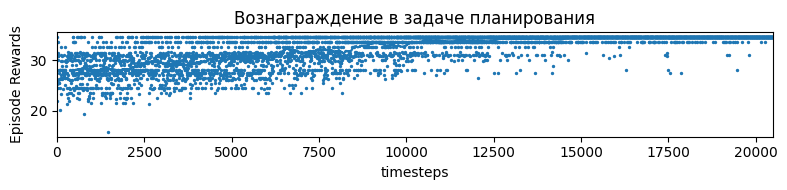

In [44]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Вознаграждение в задаче планирования"
)
# Точки это вознаграждение в конкретном эпизоде (агент иногда совершает исследовательские ходы, 
# поэтому иногда ему удается получить максимальную награду)

In [49]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Усредненная (по 50 эпизодам) кривая обучения в задаче планирования"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Номер шага")
    plt.ylabel("Вознаграждение")
    plt.title(title)
    plt.show()

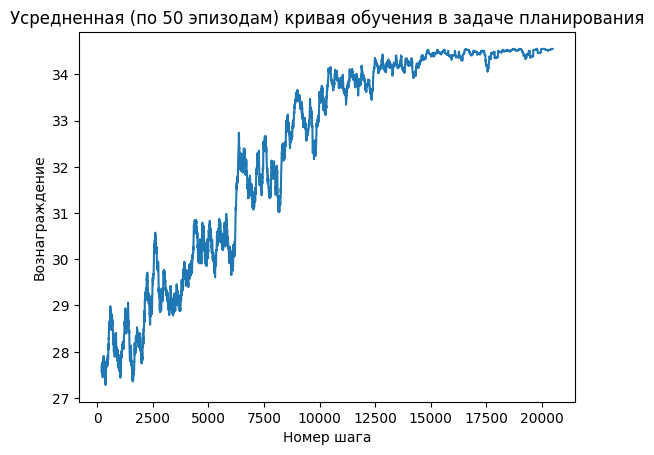

In [50]:
plot_results(log_dir)